In [1]:
import torch
import torch.nn as nn
import os
import os.path as osp
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import ImageDraw
import torch.utils.data as data
import itertools
import torch.nn.functional as F
import random

In [2]:
class Args:
    name = 'label2city'
    gpu_ids = [0, 1, 2, 3]
    checkpoints_dir = './checkpoints'
    model = 'pix2pixHD'
    norm = 'instance'
    use_dropout = True
    verbose = True
    batchSize = 1
    loadSize = 512
    fineSize = 512
    label_nc = 20
    input_nc = 3
    output_nc = 3
    dataroot = '../acgpn_dataset'
    datapairs = 'long_short.txt'
    resize_or_crop = 'scale_width'
    serial_batches = True
    no_flip = True
    nThreads = 2
    max_dataset_size = float("inf")
    display_winsize = 512
    tf_log = True
    netG = 'global'
    ngf = 64
    n_downsample_global = 4
    n_blocks_global = 4
    n_blocks_local = 3
    n_local_enhancers = 1
    niter_fix_global = 0
    continue_train = True
    display_freq = 100
    print_freq = 100
    save_latest_freq = 1000
    save_epoch_freq = 10 
    no_html = True
    debug = True
    load_pretrain = '../label2city'
    which_epoch = 'latest'
    phase = 'test'
    niter = 100
    niter_decay = 100
    beta1 = 0.5
    lr = 0.0002
    num_D = 2
    n_layers_D = 3
    ndf = 64
    lambda_feat = 10.0
    no_ganFeat_loss = True
    no_vgg_loss = False
    no_lsgan = True
    pool_size = 0
    isTrain = True

opt = Args

In [3]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    f = dir.split('/')[-1].split('_')[-1]
    dirs= os.listdir(dir)
    for img in dirs:
        path = os.path.join(dir, img)
        #print(path)
        images.append(path)
    return images

def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))

def get_transform(method=Image.BICUBIC, normalize=True):
        transform_list = []
        transform_list += [transforms.ToTensor()]
        if normalize:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
class BaseDataset(data.Dataset):
    def __init__(self, opt):
        self.opt = opt
        super(BaseDataset, self).__init__()
        
        human_names = []
        cloth_names = []
        with open(os.path.join(opt.dataroot, opt.datapairs), 'r') as f:
            for line in f.readlines():
                h_name, c_name = line.strip().split()
                human_names.append(h_name)
                cloth_names.append(c_name)
        self.human_names = human_names
        self.cloth_names = cloth_names
        
    def image_for_pose(self, pose_name, transform):
        with open(osp.join(pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))
        point_num = pose_data.shape[0]
        fine_height = 256
        fine_width = 192
        pose_map = torch.zeros(point_num, fine_height, fine_width)
        r = 5
        im_pose = Image.new('L', (fine_width, fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (fine_width, fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
        return pose_map
    
    def __getitem__(self, index):        
        c_name = self.cloth_names[index]
        h_name = self.human_names[index]
        A_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_label', h_name.replace(".jpg", ".png"))
        label = Image.open(A_path).convert('L')

        B_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_img', h_name)
        image = Image.open(B_path).convert('RGB') 
        mask = Image.open(B_path).convert('L')
        
        E_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_edge', c_name)
        edge = Image.open(E_path).convert('L')
                
        C_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_color', c_name)
        color = Image.open(C_path).convert('RGB')
        
        transform_A = get_transform(method=Image.NEAREST, normalize=False)
        label_tensor = transform_A(label) * 255
        transform_B = get_transform()      
        image_tensor = transform_B(image)
        mask_tensor = transform_A(image)
        edge_tensor = transform_A(edge)
        color_tensor = transform_B(color)
        pose_name = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_pose', h_name.replace('.jpg', '_keypoints.json'))
        pose_map = self.image_for_pose(pose_name, transform_B)
        
        return {'label': label_tensor, 'image': image_tensor, 
                             'edge': edge_tensor,'color': color_tensor, 
                             'mask': mask_tensor, 'name' : c_name,
                             'colormask': mask_tensor,'pose':pose_map}
    
    def __len__(self):
        return len(self.human_names)

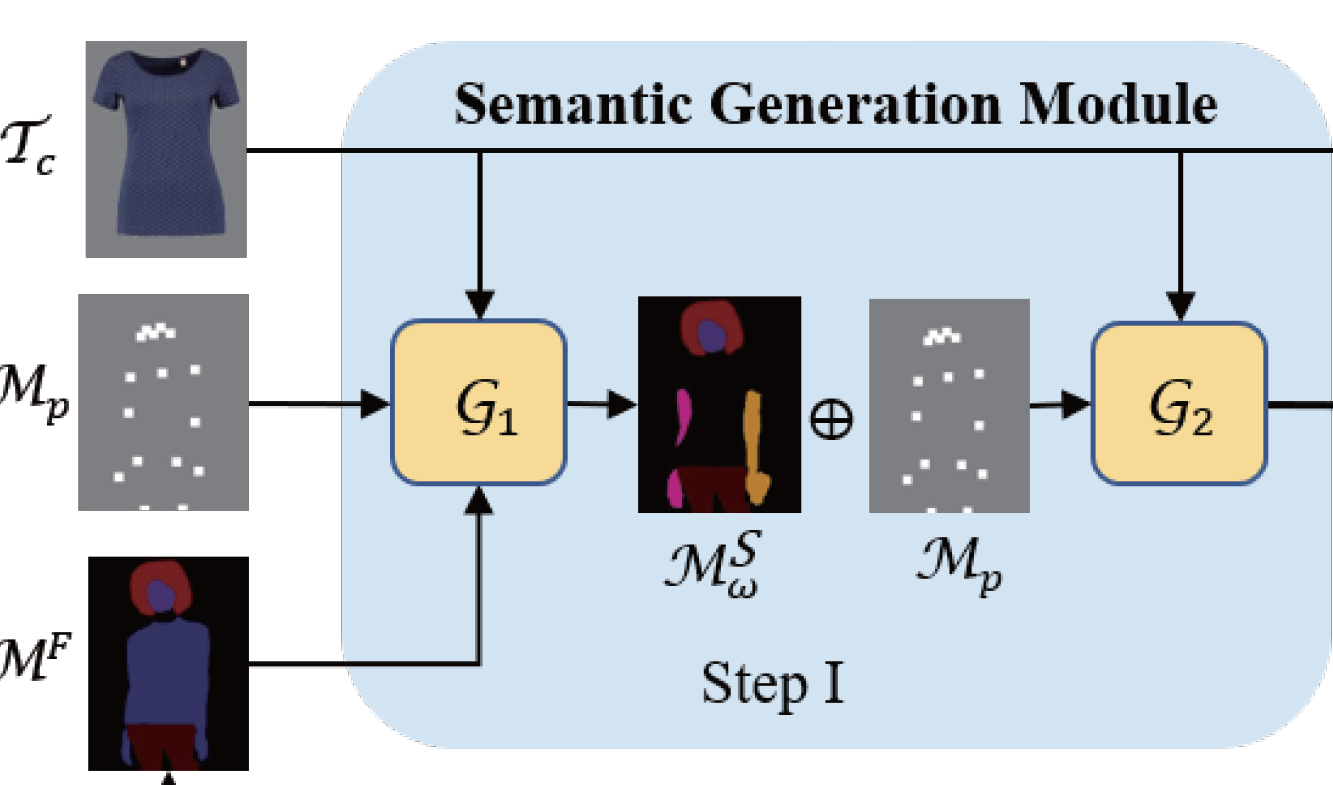

In [4]:
t = BaseDataset(opt)
dataloader = torch.utils.data.DataLoader(
            t,
            batch_size=1,
            shuffle=False)

In [5]:
len(dataloader)

6

In [6]:
from torch.autograd import Variable

def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((label.cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((label.cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

position = -1 
for data in dataloader:
    position +=1
    if position == 0:
        all_clothes_label = changearm(data['label'])
        mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
        mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
        img_fore = data['image'] * mask_fore

        in_label = Variable(data['label'].cuda())
        in_edge = Variable(data['edge'].cuda())
        in_img_fore = Variable(img_fore.cuda())
        in_mask_clothes = Variable(mask_clothes.cuda())
        in_color = Variable(data['color'].cuda())
        in_all_clothes_label = Variable(all_clothes_label.cuda())
        in_image = Variable(data['image'].cuda())
        in_pose = Variable(data['pose'].cuda())
        in_mask_fore = Variable(mask_fore.cuda()) 
        break

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

## Architecture for G

<ul>
    <li>G1 will generate semantic labels</li>
    <li>G2 generates a warped binary mask</li>
    <li>G3 combines everthing together to produce a final image</li>
<ul>

In [7]:
class Refine(nn.Module):
    def __init__(self, input_nc, output_nc=3):
        super(Refine, self).__init__()
        nl = nn.InstanceNorm2d
        self.conv1 = nn.Sequential(*[nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU()])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Sequential(*[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Sequential(*[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Sequential(*[nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU(),
                                     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU()])
        self.drop5 = nn.Dropout(0.5)

        self.up6 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512),
              nn.ReLU()])

        self.conv6 = nn.Sequential(*[nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.up7 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256),
              nn.ReLU()])
        self.conv7 = nn.Sequential(*[nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])

        self.up8 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128),
              nn.ReLU()])

        self.conv8 = nn.Sequential(*[nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])

        self.up9 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64),
              nn.ReLU()])

        self.conv9 = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(
                                         64), nn.ReLU(),
                                     nn.Conv2d(
                                         64, output_nc, kernel_size=3, stride=1, padding=1)
                                     ])

    def refine(self, input):
        conv1 = self.conv1(input)
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        conv5 = self.conv5(pool4)
        drop5 = self.drop5(conv5)

        up6 = self.up6(drop5)
        conv6 = self.conv6(torch.cat([drop4, up6], 1))

        up7 = self.up7(conv6)
        conv7 = self.conv7(torch.cat([conv3, up7], 1))

        up8 = self.up8(conv7)
        conv8 = self.conv8(torch.cat([conv2, up8], 1))

        up9 = self.up9(conv8)
        conv9 = self.conv9(torch.cat([conv1, up9], 1))
        return conv9

In [8]:
with torch.no_grad():
    G1 = Refine(37, 14)
    G1.cuda(opt.gpu_ids[0])
    G1.load_state_dict(torch.load('../label2city/latest_net_G1.pth'))
    G1.eval()

In [9]:
with torch.no_grad():
    G2 = Refine(19+18, 1)
    G2.cuda(opt.gpu_ids[0])
    G2.load_state_dict(torch.load('../label2city/latest_net_G2.pth'))
    G2.eval()

In [10]:
import cv2

def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

def encode_input(label_map, clothes_mask,all_clothes_label):
    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label= torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label=masked_label.scatter_(1,(label_map*(1-clothes_mask)).data.long().cuda(), 1.0)

    c_label=torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label=c_label.scatter_(1,all_clothes_label.data.long().cuda(),1.0)

    input_label = Variable(input_label)

    return input_label,masked_label,c_label

pre_clothes_mask = torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
shape = pre_clothes_mask.shape
clothes = in_color*pre_clothes_mask
input_label,masked_label,all_clothes_label = encode_input(in_label,in_mask_clothes,in_all_clothes_label)
shape = pre_clothes_mask.shape

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:
masked_label.size()

torch.Size([1, 14, 256, 192])

### This is the training label 

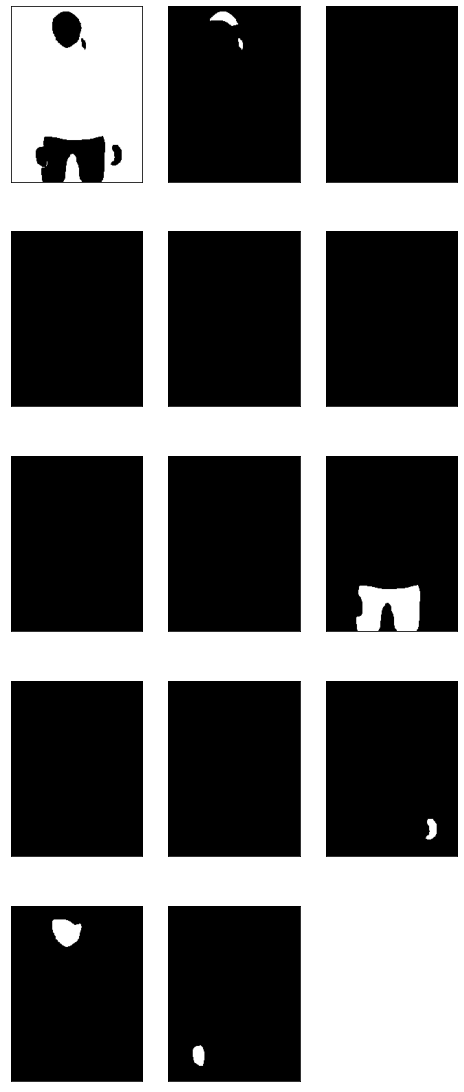

In [12]:
# 14
fig = plt.figure(figsize=(8, 20))

for i in range(14):
    ax = fig.add_subplot(5, 3, i+1)
    plt.imshow(masked_label[0][i].detach().cpu().numpy(), cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [13]:
sigmoid = nn.Sigmoid()
G1_in = torch.cat([pre_clothes_mask, clothes, all_clothes_label, in_pose, gen_noise(shape)], dim=1)
arm_label = G1.refine(G1_in)
arm_label = sigmoid(arm_label)

In [14]:
arm_label.size()

torch.Size([1, 14, 256, 192])

### This is the label when mixing up the clothing

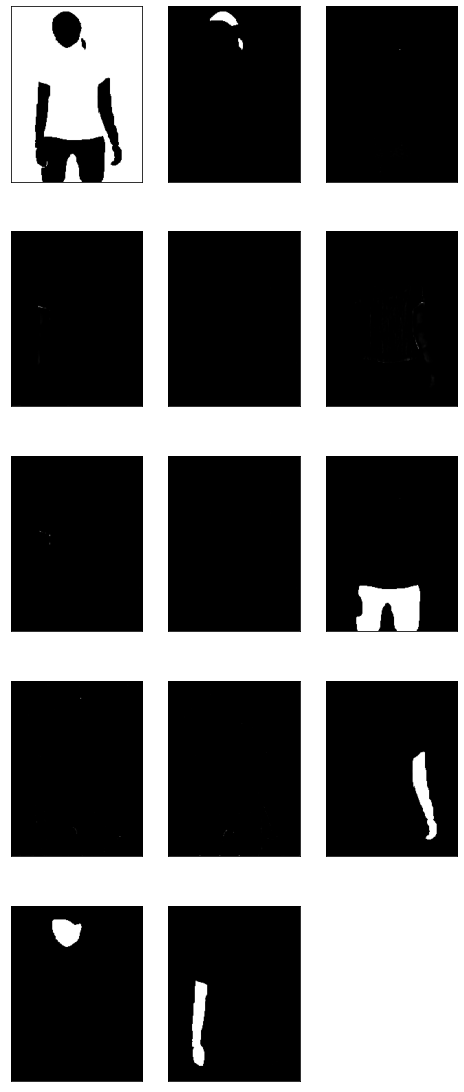

In [15]:
# 14
fig = plt.figure(figsize=(8, 20))

for i in range(14):
    ax = fig.add_subplot(5, 3, i+1)
    plt.imshow(arm_label[0][i].detach().cpu().numpy(), cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [16]:
def generate_discrete_label(inputs, label_nc, onehot=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label


armlabel_map = generate_discrete_label(arm_label.detach(), 14, False)
dis_label = generate_discrete_label(arm_label.detach(), 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


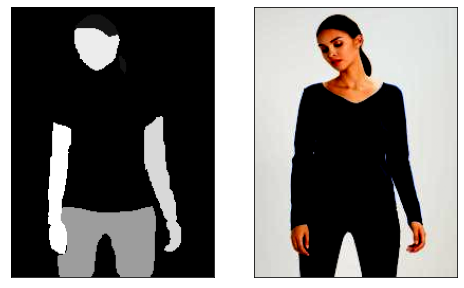

In [17]:
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(armlabel_map[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(in_image[0].permute(1,2,0).detach().cpu().numpy())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

In [18]:
G2_in = torch.cat([pre_clothes_mask,clothes, arm_label, in_pose, gen_noise(shape)],1)

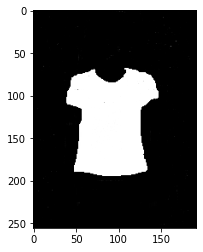

In [19]:
fake_cl = G2.refine(G2_in)
sigmoid = torch.nn.Sigmoid()
fake_cl = sigmoid(fake_cl)
plt.imshow(fake_cl[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')

In [20]:
class UnetMaskWithConstraint(nn.Module):
    def __init__(self, input_nc, output_nc=3):
        super(UnetMaskWithConstraint, self).__init__()
        self.stn = STNNet()
        nl = nn.InstanceNorm2d
        self.conv1 = nn.Sequential(*[nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU()])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Sequential(*[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Sequential(*[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Sequential(*[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv5 = nn.Sequential(*[nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU(),
                                     nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nl(1024), nn.ReLU()])
        self.drop5 = nn.Dropout(0.5)

        self.up6 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512),
              nn.ReLU()])

        self.conv6 = nn.Sequential(*[nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU(),
                                     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nl(512), nn.ReLU()])
        self.up7 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256),
              nn.ReLU()])
        self.conv7 = nn.Sequential(*[nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU(),
                                     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nl(256), nn.ReLU()])

        self.up8 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128),
              nn.ReLU()])

        self.conv8 = nn.Sequential(*[nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nl(128), nn.ReLU()])

        self.up9 = nn.Sequential(
            *[nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64),
              nn.ReLU()])

        self.conv9 = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nl(64), nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nl(
                                         64), nn.ReLU(),
                                     nn.Conv2d(
                                         64, output_nc, kernel_size=3, stride=1, padding=1)
                                     ])

    def forward(self, input, refer, mask, grid):

        input, warped_mask, rx, ry, cx, cy, grid = self.stn(
            input, torch.cat([mask, refer, input], 1), mask, grid)
        # print(input.shape)

        conv1 = self.conv1(torch.cat([refer.detach(), input.detach()], 1))
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        conv5 = self.conv5(pool4)
        drop5 = self.drop5(conv5)

        up6 = self.up6(drop5)
        conv6 = self.conv6(torch.cat([drop4, up6], 1))

        up7 = self.up7(conv6)
        conv7 = self.conv7(torch.cat([conv3, up7], 1))

        up8 = self.up8(conv7)
        conv8 = self.conv8(torch.cat([conv2, up8], 1))

        up9 = self.up9(conv8)
        conv9 = self.conv9(torch.cat([conv1, up9], 1))
        return conv9, input, warped_mask, grid

class STNNet(nn.Module):
    def __init__(self):
        super(STNNet, self).__init__()
        range = 0.9
        r1 = range
        r2 = range
        grid_size_h = 5
        grid_size_w = 5

        assert r1 < 1 and r2 < 1  # if >= 1, arctanh will cause error in BoundedGridLocNet
        target_control_points = torch.Tensor(list(itertools.product(
            np.arange(-r1, r1 + 0.00001, 2.0 * r1 / (grid_size_h - 1)),
            np.arange(-r2, r2 + 0.00001, 2.0 * r2 / (grid_size_w - 1)),
        )))
        Y, X = target_control_points.split(1, dim=1)
        target_control_points = torch.cat([X, Y], dim=1)
        self.target_control_points = target_control_points
        # self.get_row(target_control_points,5)
        GridLocNet = BoundedGridLocNet

        self.loc_net = GridLocNet(
            grid_size_h, grid_size_w, target_control_points)

        self.tps = TPSGridGen(256, 192, target_control_points)

    def get_row(self, coor, num):
        for j in range(num):
            sum = 0
            buffer = 0
            flag = False
            for i in range(num - 1):
                differ = (coor[j * num + i + 1, :] - coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ - buffer)

                buffer = differ
                sum += second_dif
            print(sum / num)

    def get_col(self, coor, num):
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            for j in range(num - 1):
                differ = (coor[(j + 1) * num + i, :] -
                          coor[j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)

                buffer = differ
                sum += second_dif
            print(sum)

    def forward(self, x, reference, mask, grid_pic):
        batch_size = x.size(0)
        source_control_points, rx, ry, cx, cy = self.loc_net(reference)
        source_control_points = (source_control_points)
        source_coordinate = self.tps(source_control_points)
        grid = source_coordinate.view(batch_size, 256, 192, 2)
        transformed_x = grid_sample(x, grid, canvas=0)
        warped_mask = grid_sample(mask, grid, canvas=0)
        warped_gpic = grid_sample(grid_pic, grid, canvas=0)
        return transformed_x, warped_mask, rx, ry, cx, cy, warped_gpic

class BoundedGridLocNet(nn.Module):

    def __init__(self, grid_height, grid_width, target_control_points):
        super(BoundedGridLocNet, self).__init__()
        self.cnn = CNN(grid_height * grid_width * 2)

        bias = torch.from_numpy(np.arctanh(target_control_points.numpy()))
        bias = bias.view(-1)
        self.cnn.fc2.bias.data.copy_(bias)
        self.cnn.fc2.weight.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        points = F.tanh(self.cnn(x))
        coor = points.view(batch_size, -1, 2)
        # coor+=torch.randn(coor.shape).cuda()/10
        row = self.get_row(coor, 5)
        col = self.get_col(coor, 5)
        rx, ry, cx, cy = torch.tensor(0.08).cuda(), torch.tensor(
            0.08).cuda(), torch.tensor(0.08).cuda(), torch.tensor(0.08).cuda()
        row_x, row_y = row[:, :, 0], row[:, :, 1]
        col_x, col_y = col[:, :, 0], col[:, :, 1]
        rx_loss = torch.max(rx, row_x).mean()
        ry_loss = torch.max(ry, row_y).mean()
        cx_loss = torch.max(cx, col_x).mean()
        cy_loss = torch.max(cy, col_y).mean()

        return coor, rx_loss, ry_loss, cx_loss, cy_loss

    def get_row(self, coor, num):
        sec_dic = []
        for j in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for i in range(num-1):
                differ = (coor[:, j*num+i+1, :]-coor[:, j*num+i, :])**2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)
                    sec_dic.append(second_dif)

                buffer = differ
                sum += second_dif
        return torch.stack(sec_dic, dim=1)

    def get_col(self, coor, num):
        sec_dic = []
        for i in range(num):
            sum = 0
            buffer = 0
            flag = False
            max = -1
            for j in range(num - 1):
                differ = (coor[:, (j+1) * num + i, :] -
                          coor[:, j * num + i, :]) ** 2
                if not flag:
                    second_dif = 0
                    flag = True
                else:
                    second_dif = torch.abs(differ-buffer)
                    sec_dic.append(second_dif)
                buffer = differ
                sum += second_dif
        return torch.stack(sec_dic, dim=1)

    
class CNN(nn.Module):
    def __init__(self, num_output, input_nc=5, ngf=8, n_layers=5, norm_layer=nn.InstanceNorm2d, use_dropout=False):
        super(CNN, self).__init__()
        downconv = nn.Conv2d(5, ngf, kernel_size=4, stride=2, padding=1)
        model = [downconv, nn.ReLU(True), norm_layer(ngf)]
        for i in range(n_layers):
            in_ngf = 2 ** i * ngf if 2 ** i * ngf < 1024 else 1024
            out_ngf = 2 ** (i + 1) * ngf if 2 ** i * ngf < 1024 else 1024
            downconv = nn.Conv2d(
                in_ngf, out_ngf, kernel_size=4, stride=2, padding=1)
            model += [downconv, norm_layer(out_ngf), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1,
                            padding=1), norm_layer(64), nn.ReLU(True)]
        model += [nn.Conv2d(256, 256, kernel_size=3, stride=1,
                            padding=1), norm_layer(64), nn.ReLU(True)]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.model = nn.Sequential(*model)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, num_output)

    def forward(self, x):
        x = self.model(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
class TPSGridGen(nn.Module):
    def compute_partial_repr(self, input_points, control_points):
        N = input_points.size(0)
        M = control_points.size(0)
        pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
        # original implementation, very slow
        # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
        pairwise_diff_square = pairwise_diff * pairwise_diff
        pairwise_dist = pairwise_diff_square[:,
                                             :, 0] + pairwise_diff_square[:, :, 1]
        repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
        # fix numerical error for 0 * log(0), substitute all nan with 0
        mask = repr_matrix != repr_matrix
        repr_matrix.masked_fill_(mask, 0)
        return repr_matrix
    
    def __init__(self, target_height, target_width, target_control_points):
        super(TPSGridGen, self).__init__()
        assert target_control_points.ndimension() == 2
        assert target_control_points.size(1) == 2
        N = target_control_points.size(0)
        self.num_points = N
        target_control_points = target_control_points.float()

        # create padded kernel matrix
        forward_kernel = torch.zeros(N + 3, N + 3)
        target_control_partial_repr = self.compute_partial_repr(
            target_control_points, target_control_points)
        forward_kernel[:N, :N].copy_(target_control_partial_repr)
        forward_kernel[:N, -3].fill_(1)
        forward_kernel[-3, :N].fill_(1)
        forward_kernel[:N, -2:].copy_(target_control_points)
        forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
        # compute inverse matrix
        inverse_kernel = torch.inverse(forward_kernel)

        # create target cordinate matrix
        HW = target_height * target_width
        target_coordinate = list(itertools.product(
            range(target_height), range(target_width)))
        # print(target_coordinate)
        target_coordinate = torch.Tensor(target_coordinate)  # HW x 2
        Y, X = target_coordinate.split(1, dim=1)
        Y = Y * 2 / (target_height - 1) - 1
        X = X * 2 / (target_width - 1) - 1
        # convert from (y, x) to (x, y)
        target_coordinate = torch.cat([X, Y], dim=1)
        target_coordinate_partial_repr = self.compute_partial_repr(
            target_coordinate, target_control_points)
        target_coordinate_repr = torch.cat([
            target_coordinate_partial_repr, torch.ones(
                HW, 1), target_coordinate
        ], dim=1)

        # register precomputed matrices
        self.register_buffer('inverse_kernel', inverse_kernel)
        self.register_buffer('padding_matrix', torch.zeros(3, 2))
        self.register_buffer('target_coordinate_repr', target_coordinate_repr)

    def forward(self, source_control_points):
        assert source_control_points.ndimension() == 3
        assert source_control_points.size(1) == self.num_points
        assert source_control_points.size(2) == 2
        batch_size = source_control_points.size(0)

        Y = torch.cat([source_control_points, Variable(
            self.padding_matrix.expand(batch_size, 3, 2))], 1)
        mapping_matrix = torch.matmul(Variable(self.inverse_kernel), Y)
        source_coordinate = torch.matmul(
            Variable(self.target_coordinate_repr), mapping_matrix)
        return source_coordinate

In [21]:
with torch.no_grad():
    G3 = Refine(24, 3)
    G3.cuda(opt.gpu_ids[0])
    G3.load_state_dict(torch.load('../label2city/latest_net_G.pth'))
    G3.eval()

In [22]:
with torch.no_grad():
    unet = UnetMaskWithConstraint(4,4)
    unet.cuda(opt.gpu_ids[0])
    unet.load_state_dict(torch.load('../label2city/latest_net_U.pth'))
    unet.eval()

In [23]:
def ger_average_color(mask, arms):
    color = torch.zeros(arms.shape).cuda()
    for i in range(arms.shape[0]):
        count = len(torch.nonzero(mask[i, :, :, :]))
        if count < 10:
            color[i, 0, :, :] = 0
            color[i, 1, :, :] = 0
            color[i, 2, :, :] = 0

        else:
            color[i, 0, :, :] = arms[i, 0, :, :].sum() / count
            color[i, 1, :, :] = arms[i, 1, :, :].sum() / count
            color[i, 2, :, :] = arms[i, 2, :, :].sum() / count
    return color

In [24]:
def morpho(mask, iter, bigger=True):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    new = []
    for i in range(len(mask)):
        tem = mask[i].cpu().detach().numpy().squeeze().reshape(256, 192, 1)*255
        tem = tem.astype(np.uint8)
        if bigger:
            tem = cv2.dilate(tem, kernel, iterations=iter)
        else:
            tem = cv2.erode(tem, kernel, iterations=iter)
        tem = tem.astype(np.float64)
        tem = tem.reshape(1, 256, 192)
        new.append(tem.astype(np.float64)/255.0)
    new = np.stack(new)
    new = torch.FloatTensor(new).cuda()
    return new

def encode(label_map, size):
    label_nc = 14
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label

In [25]:
fake_cl_dis = torch.FloatTensor((fake_cl.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
fake_cl_dis = morpho(fake_cl_dis, 1, True)
arm1_mask = torch.FloatTensor((in_label.cpu().numpy() == 11).astype(np.float)).cuda()
arm2_mask = torch.FloatTensor((in_label.cpu().numpy() == 13).astype(np.float)).cuda()
skin_color = ger_average_color((arm1_mask + arm2_mask - arm2_mask * arm1_mask),
            (arm1_mask + arm2_mask - arm2_mask * arm1_mask) * in_image)
new_arm1_mask = torch.FloatTensor(
            (armlabel_map.cpu().numpy() == 11).astype(np.float)).cuda()
new_arm2_mask = torch.FloatTensor(
            (armlabel_map.cpu().numpy() == 13).astype(np.float)).cuda()

fake_cl_dis = fake_cl_dis*(1 - new_arm1_mask)*(1-new_arm2_mask)
fake_cl_dis *= in_mask_fore

arm1_occ = in_mask_clothes * new_arm1_mask
arm2_occ = in_mask_clothes * new_arm2_mask
bigger_arm1_occ = morpho(arm1_occ, 10)
bigger_arm2_occ = morpho(arm2_occ, 10)

occlude = (1 - bigger_arm1_occ * (arm2_mask + arm1_mask+in_mask_clothes)) * \
            (1 - bigger_arm2_occ * (arm2_mask + arm1_mask+in_mask_clothes))
img_hole_hand = in_img_fore * \
            (1 - in_mask_clothes) * occlude * (1 - fake_cl_dis)
dis_label = encode(armlabel_map, armlabel_map.shape)

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel pa

In [26]:
def grid_sample(input, grid, canvas=None):
    output = F.grid_sample(input, grid)
    if canvas is None:
        return output
    else:
        input_mask = Variable(input.data.new(input.size()).fill_(1))
        output_mask = F.grid_sample(input_mask, grid)
        padded_output = output * output_mask + canvas * (1 - output_mask)
        return padded_output

tanh = torch.nn.Tanh()
fake_c, warped, warped_mask, warped_grid = unet(
            clothes, fake_cl_dis, pre_clothes_mask, in_pose)
composition_mask = fake_c[:, 3, :, :]
composition_mask= sigmoid(composition_mask)

mask = fake_c[:, 3, :, :]
mask = sigmoid(mask)*fake_cl_dis
fake_c = tanh(fake_c[:, 0:3, :, :])
fake_c = fake_c*(1-mask)+mask*warped

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


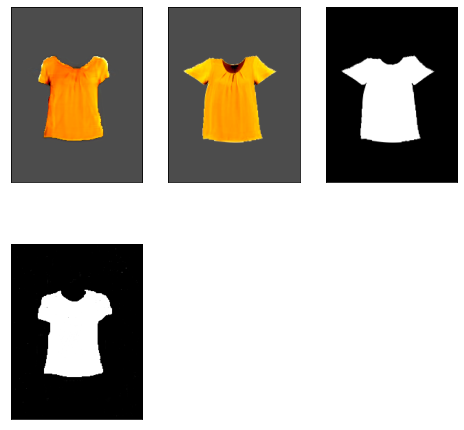

In [27]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 3, 1)
plt.imshow(fake_c[0].permute(1,2,0).detach().cpu().numpy()+0.3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 2)
plt.imshow(warped[0].permute(1,2,0).detach().cpu().numpy()+0.3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 3)
plt.imshow(warped_mask[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 4)
plt.imshow(fake_cl[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

In [28]:
G3_in = torch.cat([img_hole_hand, dis_label, fake_c, skin_color, gen_noise(shape)], 1)
fake_image = G3.refine(G3_in.detach())
fake_image = tanh(fake_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


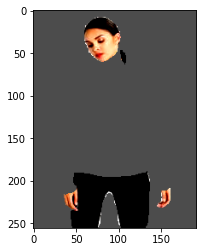

In [29]:
plt.imshow(img_hole_hand[0].permute(1,2,0).detach().cpu().numpy()+0.3)


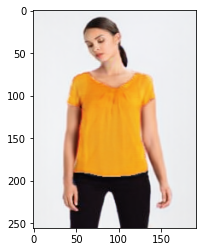

In [30]:
tensor = (fake_image[0].clone() + 1) * 0.5 * 255
tensor = tensor.cpu().clamp(0, 255)
array = tensor.detach().numpy().astype('uint8')
array = array.swapaxes(0, 1).swapaxes(1, 2)
plt.imshow(array)

In [124]:
input_pool=[G1_in,G2_in,G3_in,torch.cat([in_mask_clothes,clothes],1)]        ##fake_cl_dis to replace
real_pool=[masked_label,in_mask_clothes,in_image,in_image*in_mask_clothes]
fake_pool=[arm_label,fake_cl,fake_image,fake_c]

### Ground Truth Images

We use this to calculate the loss against the generated ones

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


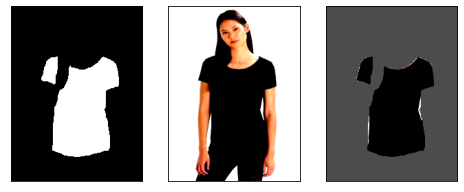

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 3, 1)
plt.imshow(in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy(), cmap='gray')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 2)
plt.imshow(in_image[0].permute(1,2,0).detach().cpu().numpy()+0.3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 3)
plt.imshow((in_image*in_mask_clothes)[0].permute(1,2,0).detach().cpu().numpy()+0.3)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## Fake Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


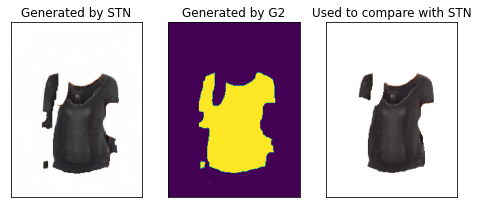

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 3, 1)
plt.imshow(fake_c[0].permute(1,2,0).detach().cpu().numpy()+1)
plt.title("Generated by STN")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 2)
plt.imshow(fake_cl[0].permute(1,2,0).detach().cpu().numpy())
plt.title("Generated by G2")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(2, 3, 3)
plt.imshow((fake_image*in_mask_clothes)[0].permute(1,2,0).detach().cpu().numpy()+1)
plt.title("Used to compare with STN")

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## How to calculate loss

In [81]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

def discriminate(netD ,input_label, test_image, use_pool=False):
    input_concat = torch.cat((input_label, test_image.detach()), dim=1)
    fake_pool = ImagePool(opt.pool_size)
    fake_query = fake_pool.query(input_concat)
    return netD.forward(fake_query)

In [82]:
from models import networks
D3 = networks.define_D(7, opt.ndf, opt.n_layers_D, opt.norm, opt.no_lsgan,
                                 opt.num_D, not opt.no_ganFeat_loss, gpu_ids=opt.gpu_ids)

fake_pool_for_stn = discriminate(D3, torch.cat([in_mask_clothes,in_color],1).detach(), fake_c, use_pool=True)
real_pool_for_stn = discriminate(D3, torch.cat([in_mask_clothes,in_color],1).detach(), in_image*in_mask_clothes, use_pool=True)

MultiscaleDiscriminator(
  (layer0): Sequential(
    (0): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (12): Sigmoid()
  )
  (layer1): Sequential(
    (0): Conv2d(7, 64, ke

In [ ]:
loss_D_fake=0
loss_D_real=0
loss_G_GAN=0
loss_G_VGG = 0

In [83]:
criterionGAN = networks.GANLoss(use_lsgan=not opt.no_lsgan, tensor=torch.cuda.FloatTensor) 
loss_D_fake += criterionGAN(fake_pool_for_stn, False)    
loss_D_real += criterionGAN(real_pool_for_stn, True)

In [84]:
input_data = torch.cat([in_mask_clothes,in_color],1)
pred_fake = D3.forward(torch.cat((input_data.detach(), fake_c), dim=1))
loss_G_GAN += criterionGAN(pred_fake, True)

In [108]:
criterionVGG = networks.VGGLoss(opt.gpu_ids)
comp_fake_c=fake_c.detach()*(1-composition_mask).unsqueeze(1)+(composition_mask.unsqueeze(1))*warped.detach()
loss_G_VGG += criterionVGG.warp(warped, in_image*in_mask_clothes)+ criterionVGG.warp(comp_fake_c, in_image*in_mask_clothes) * 10
loss_G_VGG += criterionVGG.warp(fake_c, in_image*in_mask_clothes) *20

criterionFeat = torch.nn.L1Loss()

L1_loss = criterionFeat(warped_mask,in_mask_clothes)+criterionFeat(warped, in_image*in_mask_clothes)
L1_loss+= criterionFeat(fake_c, in_image*in_mask_clothes)*0.2
L1_loss+= criterionFeat(comp_fake_c, in_image*in_mask_clothes)*10
L1_loss+= criterionFeat(composition_mask,in_mask_clothes)

C:\Users\Tasin\anaconda3\envs\improve\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1, 1, 256, 192])) that is different to the input size (torch.Size([1, 256, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


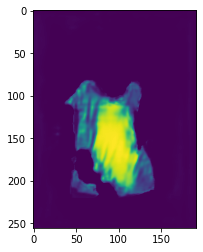

In [110]:
plt.imshow(composition_mask[0].detach().cpu().numpy()+1)
